In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
import ast
import glob
import os

In [48]:
directory = os.path.join("model_data", "Squats","Proper")
mp4_files = glob.glob(os.path.join(directory, "*.csv"))

In [49]:
mp4_files

['model_data\\Squats\\Proper\\properSquat1.csv']

In [50]:
df = pd.read_csv(mp4_files[0])
df.head()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,"[0.4244316816329956, 0.22050920128822327, -0.4...","[0.4397614896297455, 0.2081490010023117, -0.40...","[0.44688543677330017, 0.20820307731628418, -0....","[0.45620349049568176, 0.20851349830627441, -0....","[0.4105842709541321, 0.20872071385383606, -0.4...","[0.40054112672805786, 0.20926599204540253, -0....","[0.39335381984710693, 0.2100338488817215, -0.4...","[0.46951591968536377, 0.21445703506469727, -0....","[0.38441023230552673, 0.2165108174085617, -0.2...","[0.44251561164855957, 0.23559340834617615, -0....",...,"[0.5063880681991577, 0.49203425645828247, 0.02...","[0.38032233715057373, 0.49639230966567993, -0....","[0.533027172088623, 0.6365314722061157, -0.002...","[0.3569492697715759, 0.638127863407135, 0.0328...","[0.5481680035591125, 0.736966609954834, 0.4402...","[0.35661524534225464, 0.7428156137466431, 0.47...","[0.5332619547843933, 0.7448287010192871, 0.470...","[0.3717019855976105, 0.7504509687423706, 0.502...","[0.5719988346099854, 0.7900164127349854, 0.257...","[0.3386213183403015, 0.7929822206497192, 0.285..."
1,"[0.4235227406024933, 0.21684443950653076, -0.3...","[0.43903201818466187, 0.20470984280109406, -0....","[0.4468555152416229, 0.20477037131786346, -0.3...","[0.45540836453437805, 0.2048829048871994, -0.3...","[0.40920841693878174, 0.20490750670433044, -0....","[0.3998473286628723, 0.20540988445281982, -0.3...","[0.39174339175224304, 0.20587685704231262, -0....","[0.46900367736816406, 0.21041497588157654, -0....","[0.3836110830307007, 0.21121135354042053, -0.1...","[0.44183802604675293, 0.23266153037548065, -0....",...,"[0.5062860250473022, 0.49120384454727173, 0.01...","[0.38026949763298035, 0.49634894728660583, -0....","[0.5337517857551575, 0.6302443742752075, 0.024...","[0.35608652234077454, 0.6357370018959045, 0.09...","[0.5482008457183838, 0.7303119897842407, 0.440...","[0.35652613639831543, 0.7375196814537048, 0.49...","[0.5332834124565125, 0.7388057112693787, 0.470...","[0.37171733379364014, 0.7449566125869751, 0.52...","[0.5711283683776855, 0.7814869284629822, 0.271...","[0.33687734603881836, 0.7879244089126587, 0.34..."
2,"[0.4227296710014343, 0.2085539996623993, -0.32...","[0.43831613659858704, 0.1960284262895584, -0.2...","[0.44676488637924194, 0.1961459219455719, -0.2...","[0.4543534517288208, 0.1967248022556305, -0.29...","[0.40825068950653076, 0.1967441439628601, -0.2...","[0.39929160475730896, 0.19713343679904938, -0....","[0.39012810587882996, 0.19783255457878113, -0....","[0.4673558175563812, 0.2034216821193695, -0.10...","[0.38233980536460876, 0.20453612506389618, -0....","[0.4414278566837311, 0.22501909732818604, -0.2...",...,"[0.5055862665176392, 0.489584743976593, 0.0137...","[0.38004928827285767, 0.4954547882080078, -0.0...","[0.5339826345443726, 0.6249909400939941, 0.007...","[0.35355886816978455, 0.6311861276626587, 0.03...","[0.5480718016624451, 0.7260529398918152, 0.353...","[0.3564785122871399, 0.7328090071678162, 0.314...","[0.5322403311729431, 0.7342929244041443, 0.377...","[0.37170639634132385, 0.7412026524543762, 0.33...","[0.570963978767395, 0.7752067446708679, 0.2085...","[0.33661699295043945, 0.7841972708702087, 0.16..."
3,"[0.42150789499282837, 0.20228520035743713, -0....","[0.4364469349384308, 0.18947520852088928, -0.2...","[0.4458343982696533, 0.1896168440580368, -0.26...","[0.452472060918808, 0.19035115838050842, -0.26...","[0.4065835177898407, 0.18994715809822083, -0.2...","[0.39792320132255554, 0.1900908648967743, -0.2...","[0.3879556357860565, 0.19088976085186005, -0.2...","[0.4640847146511078, 0.19738951325416565, -0.0...","[0.380149245262146, 0.19864614307880402, -0.10...","[0.4403133690357208, 0.2188064306974411, -0.21...",...,"[0.5046833753585815, 0.4868897497653961, 0.010...","[0.378551185131073, 0.49287357926368713, -0.0

In [ ]:
def euclidean(joint1,joint2):
        joint1 = eval(joint1)
        joint2 = eval(joint2)
        xi,yi,zi = joint1
        xj,yj,zj = joint2
        return (np.square(xi-xj)+np.square(yi-yj)+np.square(zi-zj))**0.5

def compute_row(row):
        n = len(row)
        output = np.zeros((33,33))
        for i in range(n):
            for j in range(n):
                   output[i][j] = euclidean(row.iloc[i],row.iloc[j])
        return output[np.triu_indices(33,k=1)]
        
matrix = df.apply(lambda row: compute_row(row),axis=1)
print(matrix.shape)
#matrix[np.triu_indices(33, k=1)].shape

(107,)


In [ ]:
df.columns

Index(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
       'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
       'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'],
      dtype='object')

In [ ]:
# for squats which landmarks for relevant
# not the eyes
# not the arms
# not the ears
# not the mouth
# knees are relevant
# hips are relevant
# not the ankles
# left foot/right foot
squat_df = df.drop(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX','LEFT_THUMB', 'RIGHT_THUMB','LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'],axis=1)

In [55]:
squat_df = df

In [56]:
squat_df = squat_df.map(ast.literal_eval)

# Now squat_df contains actual lists in each cell instead of strings
# We can create three separate DataFrames for x, y, and z coordinates using list unpacking

x_coors = squat_df.map(lambda coords: coords[0])  # Get the X coordinates
y_coors = squat_df.map(lambda coords: coords[1])  # Get the Y coordinates
z_coors = squat_df.map(lambda coords: coords[2])  # Get the Z coordinates

# If you want to combine these into a single DataFrame with columns like NOSE_x, NOSE_y, NOSE_z, etc.
x_coors.columns = [f'{col}_x' for col in x_coors.columns]
y_coors.columns = [f'{col}_y' for col in y_coors.columns]
z_coors.columns = [f'{col}_z' for col in z_coors.columns]

# Combine the x, y, z data into a single DataFrame
coordinates_df = pd.concat([x_coors, y_coors, z_coors], axis=1)

# The result_df now has separate x, y, z columns for each joint
print(coordinates_df.head())

     NOSE_x  LEFT_EYE_INNER_x  LEFT_EYE_x  LEFT_EYE_OUTER_x  \
0  0.424432          0.439761    0.446885          0.456203   
1  0.423523          0.439032    0.446856          0.455408   
2  0.422730          0.438316    0.446765          0.454353   
3  0.421508          0.436447    0.445834          0.452472   
4  0.420355          0.435175    0.445124          0.451109   

   RIGHT_EYE_INNER_x  RIGHT_EYE_x  RIGHT_EYE_OUTER_x  LEFT_EAR_x  RIGHT_EAR_x  \
0           0.410584     0.400541           0.393354    0.469516     0.384410   
1           0.409208     0.399847           0.391743    0.469004     0.383611   
2           0.408251     0.399292           0.390128    0.467356     0.382340   
3           0.406584     0.397923           0.387956    0.464085     0.380149   
4           0.405064     0.396492           0.385919    0.462024     0.377923   

   MOUTH_LEFT_x  ...  LEFT_HIP_z  RIGHT_HIP_z  LEFT_KNEE_z  RIGHT_KNEE_z  \
0      0.442516  ...    0.023686    -0.023904    -0.002666

In [57]:
coordinates_df.shape

(107, 99)

In [7]:
def create_lstm_model(input_shape): # input_shape = (samples,timestamps,features)
  model = Sequential()
  model.add(LSTM(units=64, input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))  # Binary classification (correct/incorrect)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

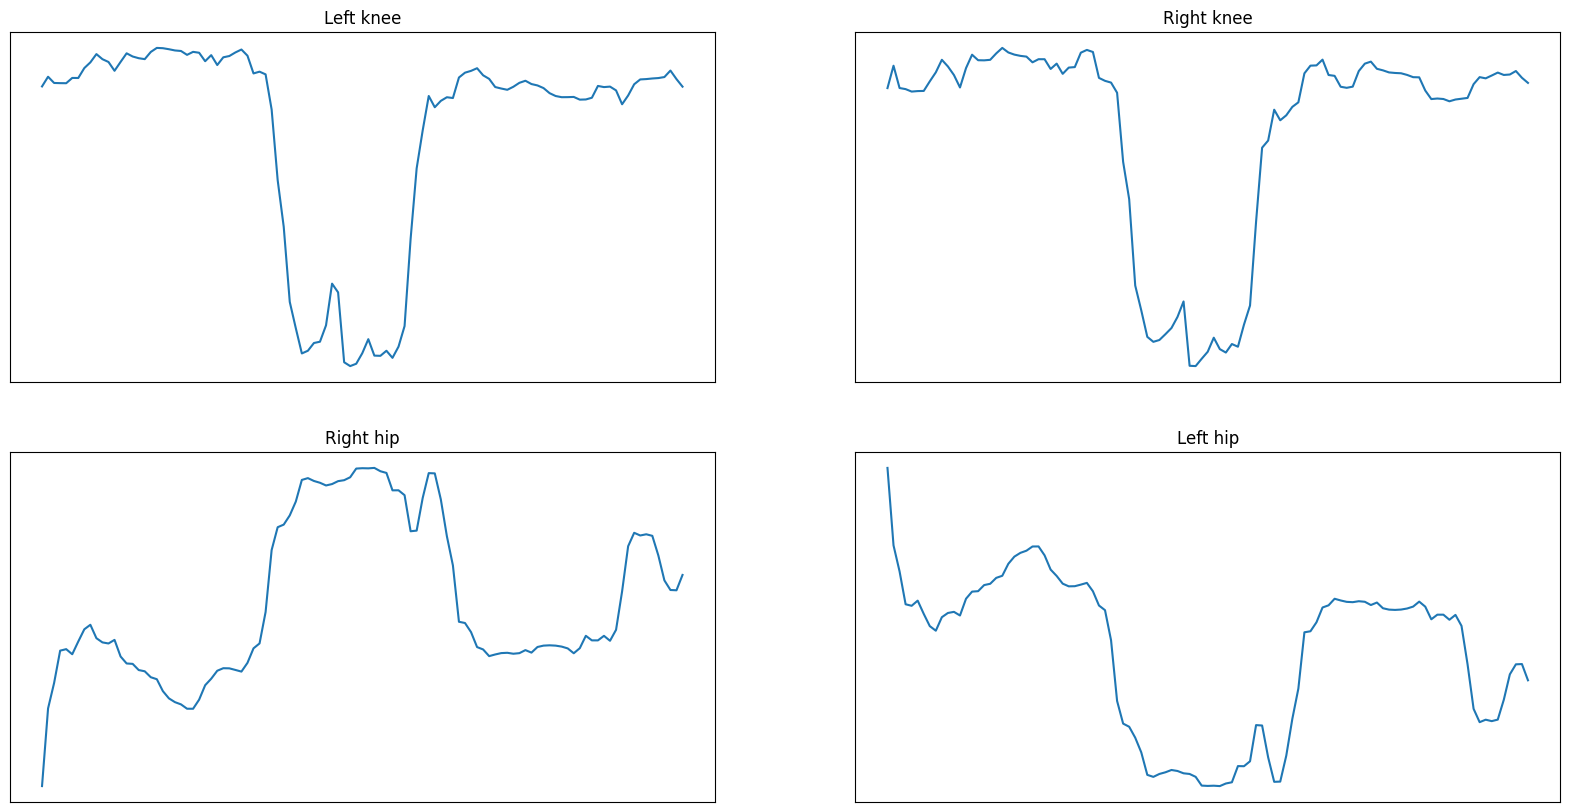

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(coordinates_df['LEFT_KNEE_z'])
plt.title('Left knee')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.plot(coordinates_df['RIGHT_KNEE_z'])
plt.title('Right knee')
plt.xticks([])
plt.yticks([])
plt.subplot(223)
plt.plot(coordinates_df['RIGHT_HIP_z'])
plt.title('Right hip')
plt.xticks([]), plt.yticks([])

# Second row, second plot: RIGHT_ELBOW_z
plt.subplot(224)
plt.plot(coordinates_df['LEFT_HIP_z'])
plt.title('Left hip')
plt.xticks([]), plt.yticks([])

plt.show()

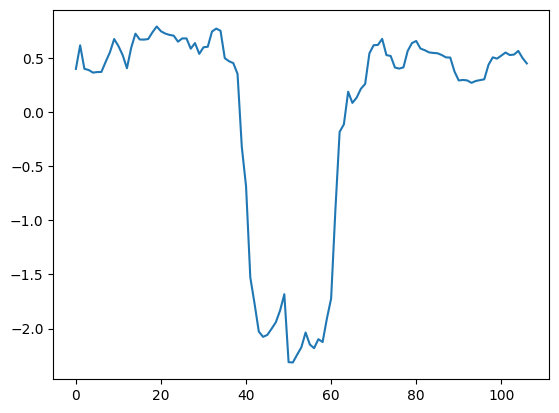

In [12]:
standard_deviation = np.std(coordinates_df['RIGHT_KNEE_z'])
mean = np.mean(coordinates_df['RIGHT_KNEE_z'])
scaled_coors = coordinates_df['RIGHT_KNEE_z'].map(lambda x: (x-mean)/standard_deviation)
plt.plot(scaled_coors)

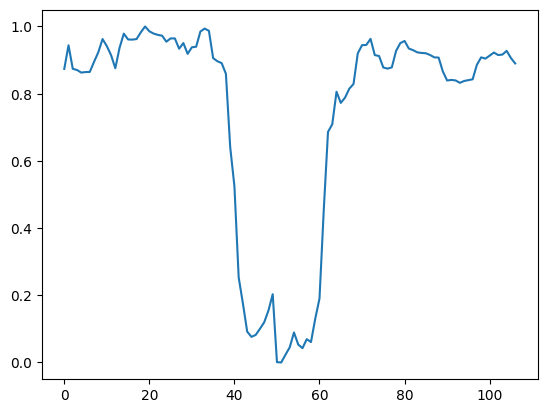

In [13]:
npMax = np.max(coordinates_df['RIGHT_KNEE_z'])
npMin = np.min(coordinates_df['RIGHT_KNEE_z'])
scaled_coors = coordinates_df['RIGHT_KNEE_z'].map(lambda x: (x-npMin)/(npMax-npMin))
plt.plot(scaled_coors) # global min will always be equal to 0 after scaling